# Post Earnings Analysis

TODO

Conclusions:

* TBD

## Data and Methodology

Papers:

* [On regression based event study](http://lipas.uwasa.fi/~sjp/articles/sp_acta_wasaensia_143_327-354.pdf)


In [2]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimizeConsensusService, EventStudyService,
    FactorService, MarketCapService, ResidualReturnsService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
calendar_service = injector.get(CalendarService)
asset_service = injector.get(AssetService)
asset_info_service = injector.get(AssetInfoService)
estimize_consensus_service = injector.get(EstimizeConsensusService)
market_cap_service = injector.get(MarketCapService)
factor_service = injector.get(FactorService)


In [132]:
def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def fix_row_index(row):
    index = row[0]
    cols = row[1]
    date = index[0]
    asset = index[1]

    if cols['bmo']:
        date = date - timedelta(days=1)

    date = calendar_service.get_valid_trading_end_date(date)

    return date, asset

def fix_index(df):
    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def shift_index(df, days):
    def shift_row_index(row):
        index = row[0]
        cols = row[1]
        date = index[0]
        asset = index[1]

        date = date + timedelta(days=days)
        date = calendar_service.get_valid_trading_end_date(date)

        return date, asset

    df.index = pd.MultiIndex.from_tuples(list(map(shift_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def get_final_consensuses(start_date, end_date):
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    fix_index(df)
    
    return df

def get_asset_returns(start_date, end_date, assets):
    df = asset_service.get_returns(start_date, end_date, assets)[['intra_day_return', 'inter_day_return', 'open_return']]

    return df

def get_benchmark_returns(start_date, end_date):
    spy = asset_service.get_asset('SPY')
    df = asset_service.get_returns(start_date, end_date, [spy])[['intra_day_return', 'inter_day_return']]
    df.reset_index(inplace=True)
    df.set_index(['as_of_date'], inplace=True)
    df.drop(['asset'], axis=1, inplace=True)
    df.rename(columns={
        'intra_day_return': 'benchmark_intra_day_return',
        'inter_day_return': 'benchmark_inter_day_return'
    }, inplace=True)

    return df

def shift_date_fn(days):
    if days > 0:
        index = -1
    else:
        index = 0
    
    def shift_date(date):
        if days != 0:
            return calendar_service.get_n_trading_days_from(days, date)[index]
        else:
            return date
    
    return shift_date 

def get_residual_returns(eps_deltas):
    df = eps_deltas
    
    df.reset_index(inplace=True)
    df['estimation_as_of_date'] = df['as_of_date'].map(shift_date_fn(-2))
    df.rename(columns={'as_of_date': 'original_as_of_date'}, inplace=True)
    df.rename(columns={'estimation_as_of_date': 'as_of_date'}, inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    start_date = df.index.get_level_values('as_of_date').min() - timedelta(days=7)
    end_date = df.index.get_level_values('as_of_date').max() + timedelta(days=7)
    assets = dfutils.unique_assets(df)
    fdf = factor_service.get_market_factors(start_date, end_date, assets)
    
    df = df.join(fdf, how='inner')
    df.reset_index(inplace=True)
    df.drop('as_of_date', axis=1, inplace=True)
    df.rename(columns={'original_as_of_date': 'as_of_date'}, inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    ardf = get_asset_returns(start_date, end_date, assets)
    brdf = get_benchmark_returns(start_date, end_date)
    
    for i in [-1, 0, 1, 2, 3]:
        df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(i)), 'as_of_date')
        
        df = df.join(ardf, how='inner')
        df.reset_index(inplace=True)
        df.set_index('as_of_date', inplace=True)

        df = df.join(brdf, how='inner')
        df.reset_index(inplace=True)
        df.set_index(['as_of_date', 'asset'], inplace=True)

        df['inter_day_residual_return_{}'.format(i)] = df['inter_day_return'] - (df['alpha'] + (df['beta'] * df['benchmark_inter_day_return']))
        df['intra_day_residual_return_{}'.format(i)] = df['intra_day_return'] - (df['alpha'] + (df['beta'] * df['benchmark_intra_day_return']))
        df['open_return_{}'.format(i)] = df['open_return']
        
        df.drop(['inter_day_return', 'intra_day_return', 'benchmark_inter_day_return', 'benchmark_intra_day_return', 'open_return'], axis=1, inplace=True)
        
        df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(-i)), 'as_of_date')
    
    df.drop(['alpha', 'beta'], axis=1, inplace=True)
    
    return df
    
def get_observations(start_date, end_date):
    aidf = asset_info_service.get_asset_info()
    
    df = get_final_consensuses(start_date, end_date)
    df.reset_index(inplace=True)
    df.set_index('asset', inplace=True)
    df = df.join(aidf, how='inner')
    df.reset_index(inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    df = get_residual_returns(df)
    
    assets = dfutils.unique_assets(df)
    mcdf = market_cap_service.get_market_caps(start_date, end_date, assets)
    df = df.join(mcdf, how='inner')
    
    print(df.head())
    
    return df

def normalize_values(values):
    return 2 * (values - values.min()) / (values.max() - values.min())  - 1


## EPS Deltas

23516
min:  -0.49299764352818715
avg:  0.03131606680287623
max:  0.5837226401663144
std:  0.22629318956879363


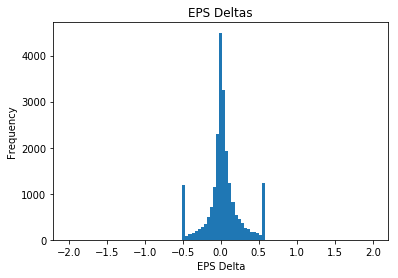

In [8]:
start_date = '2012-01-01'
end_date = '2017-10-01'

edf = get_final_consensuses(start_date, end_date)
print(len(edf))

edf['value'] = (edf['actual.eps'] - edf['estimize.eps.weighted']) / (np.abs(edf['estimize.eps.weighted']) + 0.01)
edf.dropna(inplace=True)
edf['value'] = stats.mstats.winsorize(edf.value, limits=[0.05, 0.05])

print('min: ', edf.value.min())
print('avg: ', edf.value.mean())
print('max: ', edf.value.max())
print('std: ', edf.value.std())

bins = np.linspace(-2, 2, 100)

plt.hist(edf.value, bins)
plt.title("EPS Deltas")
plt.xlabel("EPS Delta")
plt.ylabel("Frequency")
plt.show()

In [133]:
# Run all-time event study with wallstreet estimates

start_date = '2012-01-01'
end_date = '2017-10-01'

df = get_observations(start_date, end_date)

                                fiscal_year  fiscal_quarter reports_at_date  \
as_of_date asset                                                              
2012-01-31 Equity(2453 [FTNT])         2011               4      2012-01-31   
           Equity(2730 [AMZN])         2011               4      2012-01-31   
           Equity(2926 [HSY])          2011               4      2012-02-01   
2012-02-01 Equity(894 [GMCR])          2012               1      2012-02-01   
           Equity(2795 [CMG])          2011               4      2012-02-01   

                                  bmo  estimize.eps.weighted  \
as_of_date asset                                               
2012-01-31 Equity(2453 [FTNT])  False               0.142774   
           Equity(2730 [AMZN])  False               0.230810   
           Equity(2926 [HSY])    True               0.716242   
2012-02-01 Equity(894 [GMCR])   False               0.400690   
           Equity(2795 [CMG])   False               1.871884  

22927
22882
0: Information Technology
1: Consumer Discretionary
2: Consumer Staples
3: Industrials
4: Financials
5: Health Care
6: Energy
7: Utilities
8: Materials
9: Telecommunication Services
min:  -3.7519422194879026
avg:  0.4417081578738433
max:  4.972841583138352
std:  2.0605216077662516
                            OLS Regression Results                            
Dep. Variable:        residual_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.38
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           2.26e-28
Time:                        09:01:22   Log-Likelihood:                 37687.
No. Observations:               22882   AIC:                        -7.534e+04
Df Residuals:                   22866   BIC:                        -7.521e+04
Df Model:                          15                                     

(-0.6, 0.6)

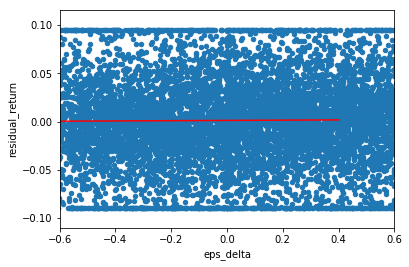

In [137]:
rdf = df.reset_index()
print(len(rdf))

rdf = rdf[['asset', 'sector', 'market_cap', 'market_cap_type', 
           'actual.eps', 'estimize.eps.weighted', 'estimize.eps.sd', 
           'inter_day_residual_return_1', 'intra_day_residual_return_1', 
           'inter_day_residual_return_2', 'intra_day_residual_return_2', 
           'inter_day_residual_return_3', 'intra_day_residual_return_3',
           'open_return_0', 'open_return_1', 'open_return_2'
          ]]
rdf.dropna(inplace=True)
print(len(rdf))

rdf['eps_diff'] = rdf['actual.eps'] - rdf['estimize.eps.weighted']
# rdf['eps_delta'] = rdf['eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)
rdf['eps_delta'] = rdf['eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
# rdf['residual_return'] = rdf['inter_day_residual_return_1']
# rdf['residual_return'] = rdf['inter_day_residual_return_1'] + rdf['intra_day_residual_return_1']
# rdf['residual_return'] = rdf['intra_day_residual_return_1']
# rdf['residual_return'] = rdf['intra_day_residual_return_1'] + rdf['inter_day_residual_return_2'] + rdf['intra_day_residual_return_2'] + rdf['inter_day_residual_return_3'] + rdf['intra_day_residual_return_3']

rdf['residual_return'] = rdf['open_return_1'] + rdf['open_return_2']

rdf['eps_delta'] = stats.mstats.winsorize(rdf.eps_delta, limits=[0.05, 0.05])
rdf['residual_return'] = stats.mstats.winsorize(rdf.residual_return, limits=[0.05, 0.05])
rdf['inter_day_residual_return_1'] = stats.mstats.winsorize(rdf.inter_day_residual_return_1, limits=[0.05, 0.05])

# rdf = rdf[np.abs(stats.zscore(rdf['eps_delta'])) < 3]
# rdf = rdf[np.abs(stats.zscore(rdf['residual_return'])) < 3]

def expanding_z_score(values):
    mean = values.expanding().mean()
    std = values.expanding().std()
    return (values - mean) / std

rdf['h_eps_delta_z'] = rdf.groupby('asset')['eps_diff'].transform(expanding_z_score)
rdf.h_eps_delta_z.fillna(0.0, inplace=True)

market_cap_types = ['Micro', 'Small', 'Mid', 'Large', 'Mega']
market_cap_columns = []
for i, m in enumerate(market_cap_types):
    col = 'market_cap_{}'.format(i + 1)
    rdf[col] = (rdf.market_cap_type == m) * rdf.eps_delta
    market_cap_columns.append(col)
    
sectors = rdf.sector.unique()
sector_columns = []
for i, s in enumerate(sectors):
    print('{}: {}'.format(i, s))
    col = 'sector_{}'.format(i)
    rdf[col] = (rdf.sector == s) * rdf.eps_delta
    sector_columns.append(col)

rdf['eps_delta_s2'] = rdf.eps_delta * rdf.eps_delta
rdf['eps_delta_s3'] = rdf.eps_delta * rdf.eps_delta * rdf.eps_delta

print('min: ', rdf.eps_delta.min())
print('avg: ', rdf.eps_delta.mean())
print('max: ', rdf.eps_delta.max())
print('std: ', rdf.eps_delta.std())

# model_columns = ['eps_delta']  # R2 = 13.6%
# model_columns = ['eps_delta', 'eps_delta_s2', 'eps_delta_s3'] # R2 = 16.7% (with winsorization)
# model_columns = ['eps_delta', 'eps_delta_s2', 'eps_delta_s3'] + market_cap_columns # R2 = 17.0%
# model_columns = ['eps_delta', 'eps_delta_s2', 'eps_delta_s3'] + market_cap_columns + sector_columns # R2 = 17.5%
# model_columns = ['eps_delta', 'h_eps_delta_z', 'eps_delta_s2', 'eps_delta_s3'] + market_cap_columns + sector_columns # R2 = 19.4%
model_columns = ['eps_delta', 'eps_delta_s3'] + market_cap_columns + sector_columns # R2 = 19.7%
# model_columns = ['eps_delta', 'eps_delta_s3', 'inter_day_residual_return_1'] + market_cap_columns + sector_columns # R2 = ?

value_column = 'residual_return'

X = rdf[model_columns]
X = sm.add_constant(X)
y = rdf[value_column]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

p = model.params

# generate x-values for your regression line (two is sufficient)
x = np.arange(-0.6, 0.8)

# scatter-plot data
ax = rdf.plot(x=model_columns[0], y=value_column, kind='scatter')

# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + p[model_columns[0]] * x, color='red')
ax.set_xlim([-0.6, 0.6])

In [123]:
import sklearn.neural_network as nn
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

rdf = df.reset_index()
print(len(rdf))

rdf = rdf[['asset', 'sector', 'market_cap', 'market_cap_type', 'actual.eps', 'estimize.eps.sd', 'estimize.eps.weighted', 'inter_day_residual_return_1', 'intra_day_residual_return_1', 'inter_day_residual_return_2', 'intra_day_residual_return_2', 'inter_day_residual_return_3', 'intra_day_residual_return_3']]
rdf.dropna(inplace=True)
print(len(rdf))

rdf['eps_diff'] = rdf['actual.eps'] - rdf['estimize.eps.weighted']
# rdf['eps_delta'] = rdf['eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)
rdf['eps_delta'] = rdf['eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['residual_return'] = rdf['inter_day_residual_return_1']
# rdf['residual_return'] = rdf['intra_day_residual_return_1']
# rdf['residual_return'] = rdf['intra_day_residual_return_1'] + rdf['inter_day_residual_return_2'] + rdf['intra_day_residual_return_2'] + rdf['inter_day_residual_return_3'] + rdf['intra_day_residual_return_3']

def expanding_z_score(values):
    mean = values.expanding().mean()
    std = values.expanding().std()
    return (values - mean) / std

rdf['h_eps_delta_z'] = rdf.groupby('asset')['eps_diff'].transform(expanding_z_score)
rdf.h_eps_delta_z.fillna(0.0, inplace=True)

rdf['eps_delta'] = stats.mstats.winsorize(rdf.eps_delta, limits=[0.05, 0.05])
rdf['inter_day_residual_return_1'] = stats.mstats.winsorize(rdf.inter_day_residual_return_1, limits=[0.05, 0.05])
rdf['residual_return'] = stats.mstats.winsorize(rdf.residual_return, limits=[0.05, 0.05])

sectors = rdf.sector.unique()
sector_columns = []
for i, s in enumerate(sectors):
    col = 'sector_{}'.format(i)
    rdf[col] = (rdf.sector == s)
    sector_columns.append(col)

# model_columns = ['eps_delta']
model_columns = ['eps_delta', 'market_cap'] + sector_columns  # R2 = ?
# model_columns = ['eps_delta', 'h_eps_delta_z', 'market_cap'] + sector_columns  # R2 = 20.5%

print(model_columns)
    
rdf['residual_return'] = 2 * (rdf.residual_return - rdf.residual_return.min()) / (rdf.residual_return.max() - rdf.residual_return.min())  - 1

print(rdf.residual_return.min())
print(rdf.residual_return.mean())
print(rdf.residual_return.max())

train, test = np.split(rdf.sample(frac=1), [int(.8*len(rdf))])
print('train: ', len(train))
print('test: ', len(test))

X_train = train[model_columns]
scaler.fit(X_train)
X_train = scaler.transform(X_train)
y_train = train['residual_return']

# model = nn.MLPRegressor(
#     hidden_layer_sizes=(22,),
#     activation='tanh',
#     solver='lbfgs',
#     max_iter=400,
#     verbose=True
# )

model = nn.MLPRegressor(
    hidden_layer_sizes=(7,),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    verbose=True
)

results = model.fit(X_train, y_train)

score_train = results.score(X_train, y_train)
print('train score: ', score_train)

# Test
X_test = test[model_columns]
X_test = scaler.transform(X_test)
y_test = test['residual_return']

score_test = results.score(X_test, y_test)
print('test score: ', score_test)



22927
22882
['eps_delta', 'market_cap', 'sector_0', 'sector_1', 'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7', 'sector_8', 'sector_9']
-1.0
0.039391837966632585
1.0
train:  18305
test:  4577
train score:  0.20553699887364119
test score:  0.194394548761613
